In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

In [16]:
import datetime

anlik_zaman1 = datetime.datetime.now()

print("Anlık zaman1:", anlik_zaman1)


Anlık zaman1: 2023-04-08 21:10:13.180064


In [17]:
torch.manual_seed(190401041)

In [18]:
# Veri setini yukle
train_data = pd.read_csv("/content/cure_the_princess_train.csv")

# Veri setini yukle
test_data = pd.read_csv("/content/cure_the_princess_test.csv")

# Veri setini yukle
validation_data = pd.read_csv("/content/cure_the_princess_validation.csv")

In [19]:
from torch.utils.data import DataLoader, TensorDataset

# TensorDataset kullanarak train, test ve validation setlerini olusturuyoruz
train_inputs = train_data.drop('Cured', axis=1).values
train_labels = train_data['Cured'].values
train_dataset = TensorDataset(torch.tensor(train_inputs, dtype=torch.float), torch.tensor(train_labels, dtype=torch.long))

val_inputs = validation_data.drop('Cured', axis=1).values
val_labels = validation_data['Cured'].values
val_dataset = TensorDataset(torch.tensor(val_inputs, dtype=torch.float), torch.tensor(val_labels, dtype=torch.long))

test_inputs = test_data.drop('Cured', axis=1).values
test_labels = test_data['Cured'].values
test_dataset = TensorDataset(torch.tensor(test_inputs, dtype=torch.float), torch.tensor(test_labels, dtype=torch.long))


# DataLoader kullanarak train, test ve validation setlerini batch'ler halinde modele veriyoruz
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)
validation_dataloader = DataLoader(val_dataset, batch_size=16)

In [20]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

input_dim = len(train_data.columns) - 1 # Ozellik sayisi
hidden_dim1 = 100
hidden_dim2 = 50
output_dim = 1 # Siniflandirma yapilacagi için 1 çikis noronu yeterli

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP(input_dim, hidden_dim1, hidden_dim2, output_dim).to(device)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)



In [21]:
# Epoch sayısı
num_epochs = 50

# Train ve validation loss listelerini olustur
train_losses = []
valid_losses = []

# Egitim dongusu
for epoch in range(num_epochs):
    # Egitim modunda ilerle
    model.train()
    correct = 0
    total = 0

    # Batch loss ve dogruluk degerlerini sifirla
    train_loss = 0.0
    train_acc = 0.0

    # Batch sayisini belirle
    num_batches = len(train_dataloader)

    # Tum batchler uzerinde ilerle
    for batch_num, (inputs, labels) in enumerate(train_dataloader):
        # Girdileri ve hedefleri tensorlere yukle
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Gradientleri sıfırla
        optimizer.zero_grad()

        # Ileri gecis yap
        outputs = model(inputs)

        # Loss hesapla ve backward pass yap
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()

        # Gradientleri guncelle
        optimizer.step()

        # Batch loss ve dogruluk degerlerini hesapla
        train_loss += loss.item()
        train_acc += (torch.round(outputs.squeeze()) == labels.float()).sum().item()

    # Batch loss ve dogruluk degerlerini ortala
    train_loss /= len(train_dataset)
    train_acc /= len(train_dataset)

    # Modeli degerlendirme moduna al
    model.eval()

    # Validation loss ve dogruluk degerlerini sifirla
    valid_loss = 0.0
    valid_acc = 0.0

    # Batch sayisini belirle
    num_batches = len(validation_dataloader)

    # Doğrulama verileri için döngü
    for inputs, labels in validation_dataloader:
        # Girdileri ve hedefleri tensorlere yukle
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass yap
        outputs = model(inputs)

        # Loss hesapla
        loss = criterion(outputs.squeeze(), labels.float())

        # Batch loss ve dogruluk degerlerini hesapla
        valid_loss += loss.item()
        valid_acc += (torch.round(outputs.squeeze()) == labels.float()).sum().item()

    # Batch loss ve dogruluk degerlerini ortala
    valid_loss /= len(validation_dataloader.dataset)
    valid_acc /= len(validation_dataloader.dataset)


    # Train ve validation loss degerlerini listelere ekle
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Her epoch sonunda sonucları yazdir
    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Accuracy: {valid_acc:.4f}")


Epoch: 1/50, Train Loss: 0.0402, Validation Loss: 0.0433, Train Accuracy: 0.6773, Validation Accuracy: 0.5796
Epoch: 2/50, Train Loss: 0.0255, Validation Loss: 0.0220, Train Accuracy: 0.8283, Validation Accuracy: 0.8376
Epoch: 3/50, Train Loss: 0.0203, Validation Loss: 0.0168, Train Accuracy: 0.8722, Validation Accuracy: 0.9140
Epoch: 4/50, Train Loss: 0.0178, Validation Loss: 0.0170, Train Accuracy: 0.8914, Validation Accuracy: 0.8981
Epoch: 5/50, Train Loss: 0.0168, Validation Loss: 0.0401, Train Accuracy: 0.8874, Validation Accuracy: 0.6911
Epoch: 6/50, Train Loss: 0.0162, Validation Loss: 0.0133, Train Accuracy: 0.8978, Validation Accuracy: 0.9013
Epoch: 7/50, Train Loss: 0.0137, Validation Loss: 0.0120, Train Accuracy: 0.9241, Validation Accuracy: 0.9490
Epoch: 8/50, Train Loss: 0.0124, Validation Loss: 0.0229, Train Accuracy: 0.9305, Validation Accuracy: 0.8471
Epoch: 9/50, Train Loss: 0.0119, Validation Loss: 0.0180, Train Accuracy: 0.9369, Validation Accuracy: 0.8790
Epoch: 10/

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# En iyi modeli kullanarak test seti üzerinde tahmin yapın
model.eval()
y_true = []
y_pred = []

for inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    predictions = torch.round(outputs.squeeze())
    y_true += labels.tolist()
    y_pred += predictions.tolist()

# Test seti üzerinde ölçüt değerlerini hesaplayın
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Sonuçları yazdırın
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")


Test Accuracy: 0.9521
Test Precision: 0.9730
Test Recall: 0.9304
Test F1 Score: 0.9513


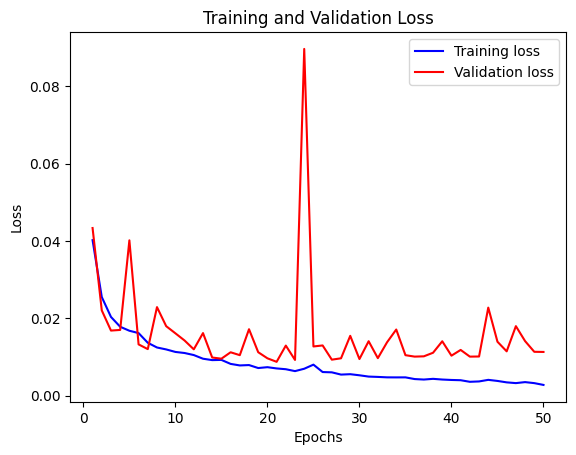

In [23]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, valid_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [24]:
anlik_zaman2 = datetime.datetime.now()

print("Geçen Süre:", anlik_zaman2 - anlik_zaman1)

Geçen Süre: 0:00:11.142654
